#构建CNN模型

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv1D,InputLayer,Convolution1D,MaxPooling1D,BatchNormalization,Concatenate,Input

seq_len, filter_len = 118, 8
nbr_filters, nodes = 120, 100
dropout = (0.5, 0)
layers, border_mode = 2 , 'same'

''' Build model archicture and fit.'''
model = Sequential()
if layers >= 1:
    model.add(Conv1D(activation="relu", input_shape=(seq_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
if layers >= 2:
    model.add(Conv1D(activation="relu", input_shape=(seq_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    model.add(Dropout(dropout[0]))
if layers >= 3:
    model.add(Conv1D(activation="relu", input_shape=(seq_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    model.add(Dropout(dropout[0]))
model.add(Flatten())

model.add(Dense(nodes,kernel_initializer='glorot_normal',bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(Dropout(dropout[1]))

model.add(Dense(1,kernel_initializer='glorot_normal',bias_initializer='zeros'))
model.add(Activation('linear'))

#compile the model
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-08)
model.compile(loss="mean_squared_error", optimizer=adam)

# 训练模型

In [18]:
import os
import random
import numpy as np
import pandas as pd
from sklearn import preprocessing


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()

def one_hot_encode(df, col='seq', seq_len=44):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        lst = [nuc_d[x] for x in seq]
        if seq_len>len(seq):
            lst += [nuc_d['n']]*(seq_len-len(seq))
        a = np.array(lst)
        vectors[i] = a
    return vectors


set_seed(42)
datadir = "/Users/john/Desktop/sev"
e_train = pd.read_csv(f"{datadir}/train.csv")
e_test= pd.read_csv(f"{datadir}/test.csv")

seq_e_train = one_hot_encode(e_train,seq_len=seq_len)
seq_e_test = one_hot_encode(e_test, seq_len=seq_len)
label = 'score' # abs_score:0.2987 0.6760
e_test.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_test.loc[:,label].values.reshape(-1,1))
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,label].values.reshape(-1,1))
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='min', verbose=1, 
                          restore_best_weights = True)
history = model.fit(seq_e_train, e_train['scaled_rl'], batch_size=64, epochs=15,callbacks=[earlyStop], verbose=1,
                    validation_data=(seq_e_test,e_test["scaled_rl"]), shuffle=True)


Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 0.7638 - val_loss: 0.7227
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.7534 - val_loss: 0.7238
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.7533 - val_loss: 0.7178
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.7319 - val_loss: 0.7227
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 0.7469 - val_loss: 0.7190
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - loss: 0.7258 - val_loss: 0.7081
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - loss: 0.7149 - val_loss: 0.7133
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 0.7242 - val_loss: 0.7235
Epoch 9/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 0.6993 - val_loss: 0.7177
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 6.


# 评估训练效果

In [19]:
import scipy.stats as stats
from sklearn import preprocessing

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

e_test = test_data(df=e_test, model=model, obs_col=label,test_seq=seq_e_test)
r = r2(e_test[label], e_test['pred'])
pr =  stats.pearsonr(e_test[label], e_test['pred'])
print('test r-squared = ', r, "pearsonR = ", pr[0])
e_train = test_data(df=e_train, model=model, obs_col=label,test_seq=seq_e_train)
r = r2(e_train[label], e_train['pred'])
pr =  stats.pearsonr(e_train[label], e_train['pred'])
print('train r-squared = ', r, "pearsonR = ", pr[0])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
test r-squared =  0.29242714853563506 pearsonR =  0.5407653359227408
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
train r-squared =  0.31120843058541797 pearsonR =  0.5578605834663518


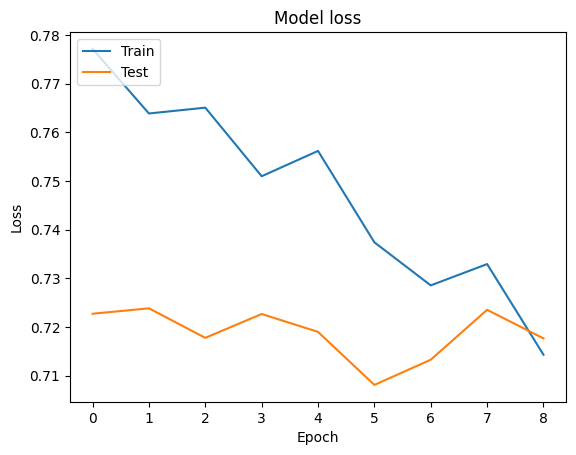

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

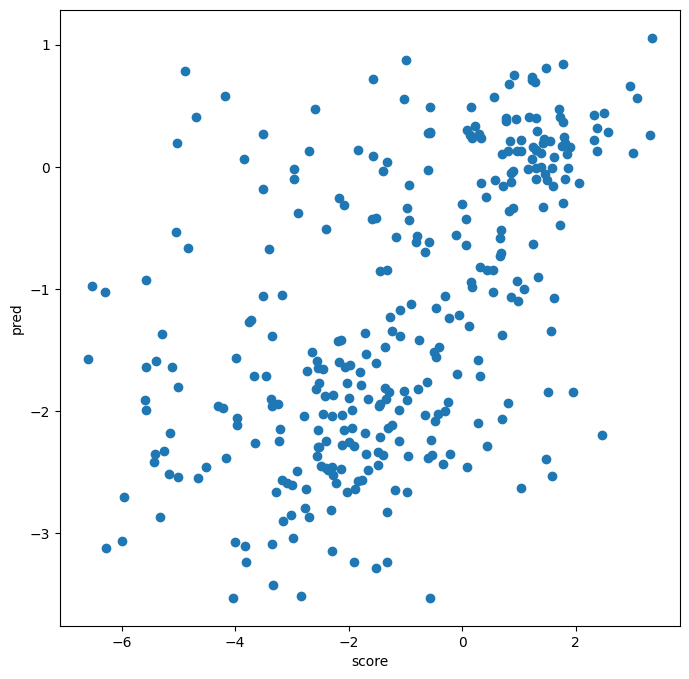

In [21]:
# e_test=pd.read_csv("test.csv")
sdf = e_test
plt.figure(figsize=(8, 8))
plt.scatter(e_test["score"], e_test["pred"], marker='o')
plt.xlabel("score")
plt.ylabel("pred")
plt.show()